In [1]:
!pip install opencv-python

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
import cv2
import zipfile
import numpy as np

faces = {}
zip_file_path = '/content/drive/My Drive/Colab_Notebooks/face_recognition/att_faces.zip'

#with zipfile.ZipFile("att_faces.zip") as facezip:   -->  if u upload file zip
with zipfile.ZipFile(zip_file_path) as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue  # not a face picture
        with facezip.open(filename) as image:
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

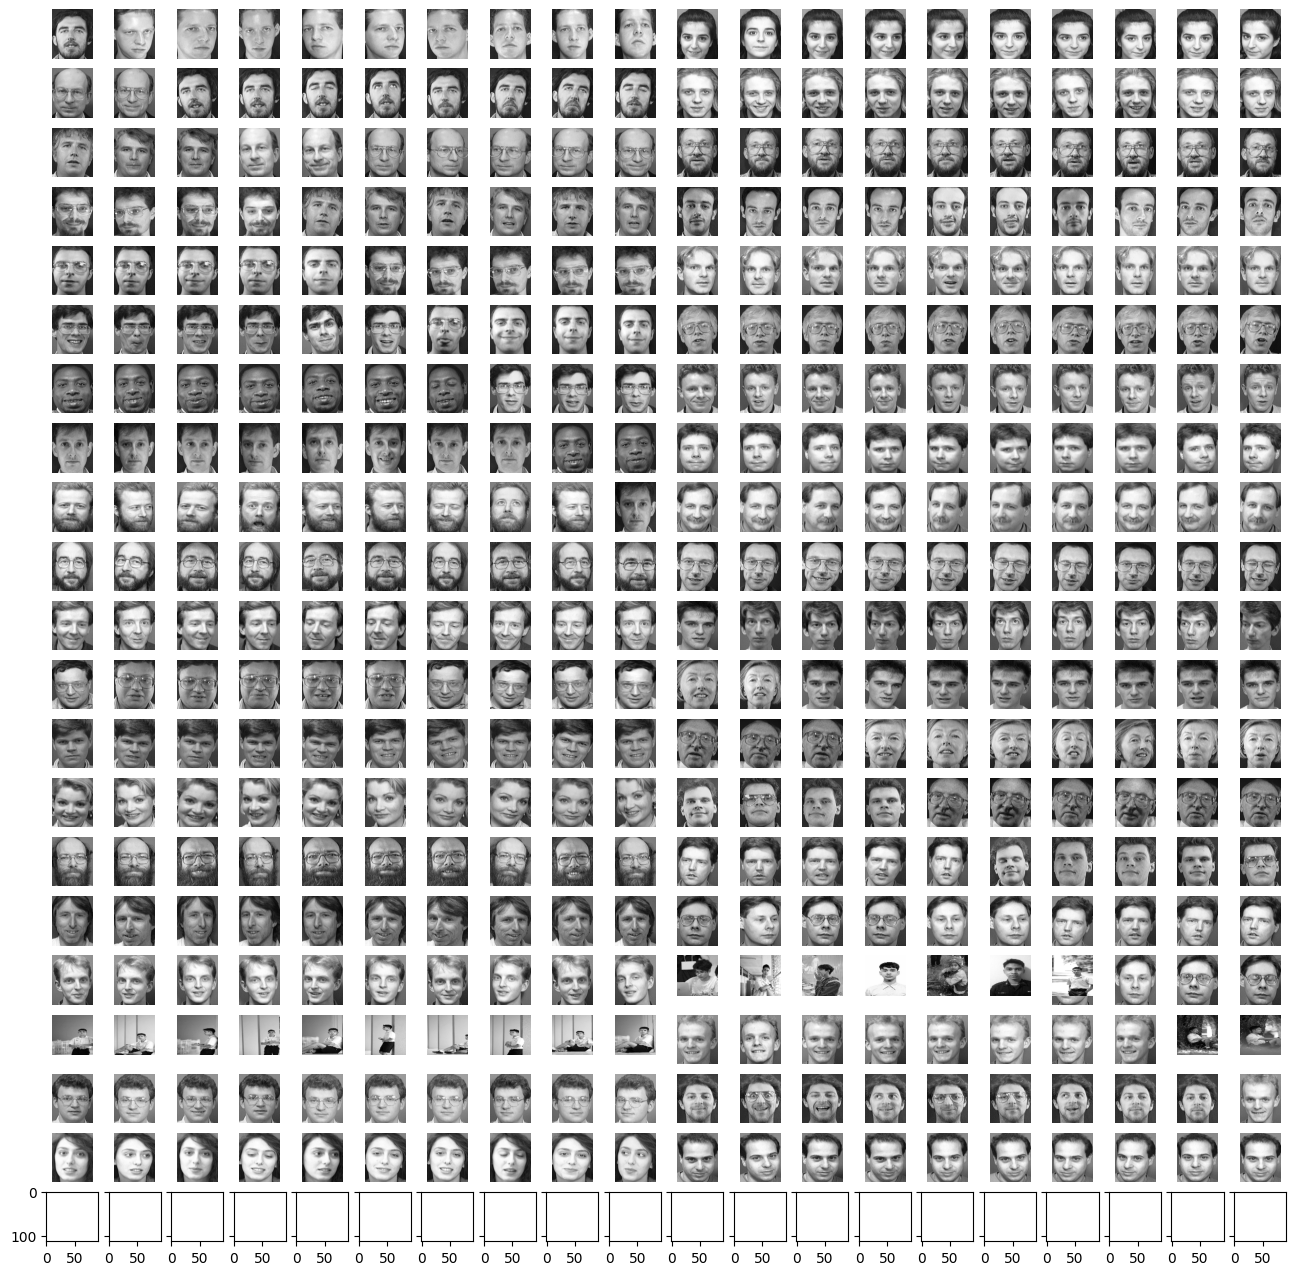

In [5]:
import matplotlib.pyplot as plt

# Assuming you have a list of 400 face images
faceimages = list(faces.values())[:420]

# Set the number of rows and columns for your grid
rows = 21  # 20 rows
columns = 20  # 20 columns
total_images = rows * columns

# Create multiple subplots to display the images in batches
fig, axes = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(16, 16))

# Iterate through the images and plot them
for i in range(total_images):
    ax = axes[i // rows, i % columns]
    ax.imshow(faceimages[i], cmap="gray")
    ax.axis("off")  # Turn off axis labels

# Show the plots
plt.show()

In [ ]:
print(faceimages[340].shape) #not yet reshape

(112, 92)


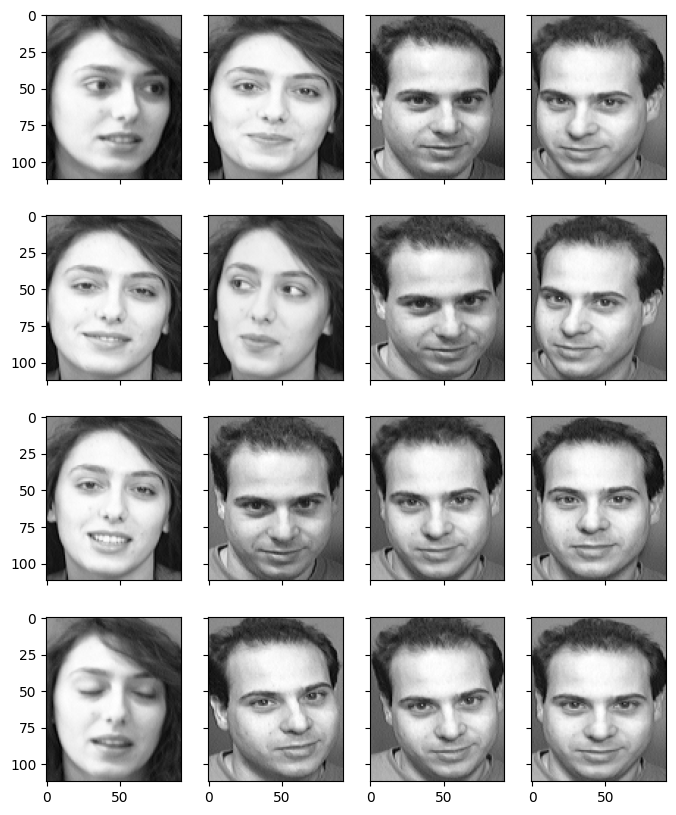

In [ ]:
...
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages= list(faces.values())[-16:]  # used last 16 images
for i in range(16):
  axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
plt.show()



In [ ]:
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

Face image shape: (112, 92)


In [ ]:
...
print(list(faces.keys())[:5])

['s1/1.pgm', 's1/10.pgm', 's1/2.pgm', 's1/3.pgm', 's1/4.pgm']


In [ ]:
...
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes", len(classes))
print("Number of pictures", len(faces))

Number of classes 42
Number of pictures 420


In [ ]:
...
# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test

facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s37/"):
        continue # this is our test set
    if key == "s40/10.pgm":
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])


  # Create facematrix as (n_samples,n_pixels) matrix
facematrix = np.array(facematrix)
print()

In [ ]:
...
#Apply PCA to ectract eigenfaces
from sklearn.decomposition import PCA

pca = PCA().fit(facematrix)
print(pca.explained_variance_ratio_)

[1.88524224e-01 1.26247653e-01 7.15919201e-02 5.65133058e-02
 4.90825360e-02 3.12887199e-02 2.28293831e-02 2.15974767e-02
 1.90658644e-02 1.70382916e-02 1.34570435e-02 1.32502848e-02
 1.04443103e-02 1.01548753e-02 9.29892432e-03 8.81235756e-03
 8.21406940e-03 7.89714107e-03 7.41150861e-03 6.70303843e-03
 6.47775295e-03 6.21492980e-03 5.89997963e-03 5.48992093e-03
 5.05857682e-03 4.95709546e-03 4.78141967e-03 4.52671867e-03
 4.47244533e-03 4.45367676e-03 4.14501219e-03 3.92368973e-03
 3.91331376e-03 3.64376126e-03 3.61180116e-03 3.51547490e-03
 3.45596830e-03 3.30855441e-03 3.14343201e-03 3.10513896e-03
 3.03671544e-03 3.00363870e-03 2.88657033e-03 2.69660176e-03
 2.67583620e-03 2.63832636e-03 2.60285632e-03 2.56261048e-03
 2.47431642e-03 2.42573716e-03 2.37599061e-03 2.32827344e-03
 2.24670218e-03 2.19602886e-03 2.16448798e-03 2.05276424e-03
 2.00440247e-03 1.98373040e-03 1.96406894e-03 1.94347539e-03
 1.91805696e-03 1.84293764e-03 1.81816223e-03 1.78914295e-03
 1.76241752e-03 1.737367

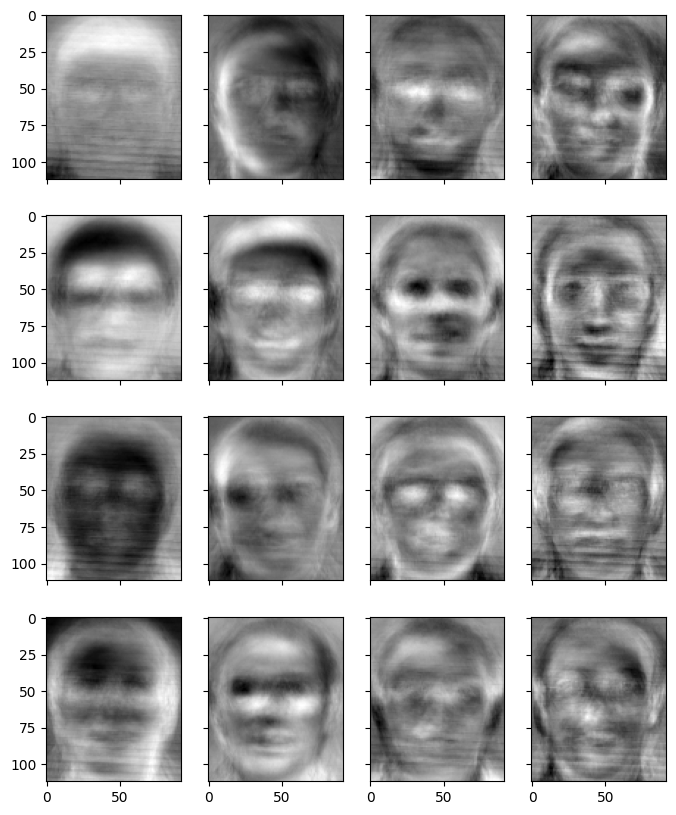

In [ ]:
...
import matplotlib.pyplot as plt
# Take the K principal components as eigenfaces
n_components = 50
eigenfaces = pca.components_[:n_components]

# Show the first 16 eigenfaces
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
  axes[i%4][i//4].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
plt.show()

In [ ]:
...
# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
weights = eigenfaces @ (facematrix - pca.mean_).T

In [ ]:
...
weights = []
for i in range(n_components):
    weight = []
    for j in range(n_components):
      w = eigenfaces[j] @ (facematrix[i] - pca.mean_)
      weight.append(w)
    weight.append(weight)

## Test on out of sample image of existiing class


### Visualize

Shape of the weight matrix: (50, 409)
Best match s22 with Euclidean distance 2793.762059


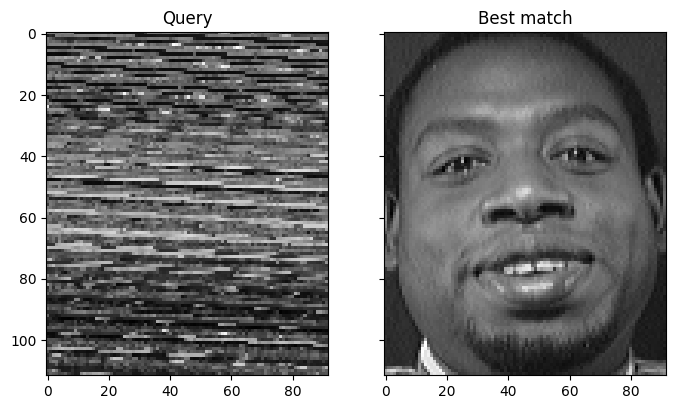

In [ ]:
# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
weights = eigenfaces @ (facematrix - pca.mean_).T
print("Shape of the weight matrix:", weights.shape)

# Test on out-of-sample image of new class (e.g., "s41")
query = faces["s41/4.pgm"].reshape(1, -1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

Shape of the weight matrix: (50, 409)
Best match s40 with Euclidean distance 0.000000


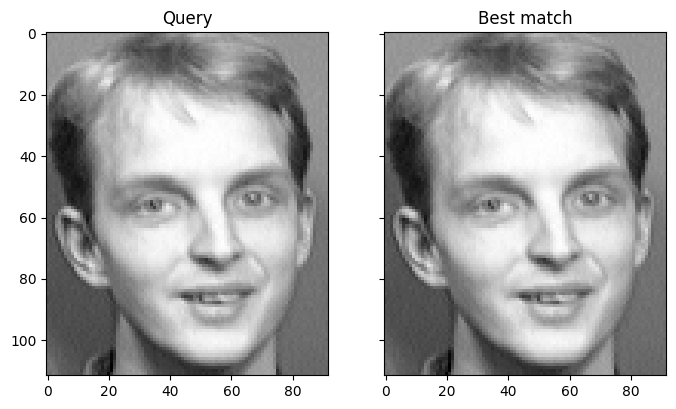

In [ ]:
# Test on out-of-sample image of new class
query = faces["s40/3.pgm"].reshape(1,-1)
print("Shape of the weight matrix:", weights.shape)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

### Drive Mount 🙂

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

### Shut mount dive path file : 🧐

In [ ]:
import shutil

# Specify the directory you want to clear
directory_to_clear = '/content/drive'

# Clear the directory (use with caution, as it will delete all files)
shutil.rmtree(directory_to_clear)

os.makedirs(directory_to_clear)

## Save by file Original file extension

---



In [ ]:
import cv2
import os

# Path to your source folder containing RGB images
source_folder = "/content/drive/MyDrive/Colab Notebooks/face_recognition/Dataset selfTrain"

# Path to the folder where you want to save the converted and resized images
destination_folder = "/content/drive/MyDrive/Colab Notebooks/face_recognition/Dataset Pinconvert"

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# List all files in the source folder
files = os.listdir(source_folder)

# Loop through each image
for file in files:
    if file.endswith(".jpg") or file.endswith(".png"):  # Change the extensions as needed
        # Read the image
        image = cv2.imread(os.path.join(source_folder, file))

        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize the image to 112x92
        resized_image = cv2.resize(gray_image, (112, 92))

        # Save the processed image to the destination folder
        cv2.imwrite(os.path.join(destination_folder, file), resized_image)


## Save by file PGM file To process
---



In [ ]:
from google.colab import drive
import cv2
import os

# drive.mount('/content/drive')

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Path to your source folder containing RGB images and save path the converted and resized images
source_folder = "/content/drive/MyDrive/Colab Notebooks/face_recognition/Dataset selfTrain"
destination_folder = "/content/drive/MyDrive/Colab Notebooks/face_recognition/Dataset Pinconvert"

# Process the Images and Save as PGM
for filename in os.listdir(source_folder):
    if filename.endswith((".jpg", ".png")):  # Adjust extensions as needed
        image_path = os.path.join(source_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if image is not None:
            resized_image = cv2.resize(image, (112, 92))
            destination_path = os.path.join(destination_folder, os.path.splitext(filename)[0] + ".pgm")
            cv2.imwrite(destination_path, resized_image)

## Research PGM file to stable 👻

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

# Define the directory where your dataset is located
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/face_recognition/Dataset Pinconvert"

# Initialize data containers
faces = {}
facematrix = []
facelabel = []

# Loop through subject directories and read PGM images
for subject_dir in os.listdir(dataset_dir):
    subject_path = os.path.join(dataset_dir, subject_dir)
    if not os.path.isdir(subject_path):
        continue  # Skip non-directory items

    for filename in os.listdir(subject_path):
        if not filename.endswith(".pgm"):
            continue  # Skip non-PGM files
        image_path = os.path.join(subject_path, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        faces[filename] = image
        facematrix.append(image.flatten())
        facelabel.append(subject_dir)

# Create a NxM matrix with N images and M pixels per image
facematrix = np.array(facematrix)

# Apply PCA and take first K principal components as eigenfaces
pca = PCA().fit(facematrix)
n_components = 50
eigenfaces = pca.components_[:n_components]

# Calculate weights for all training images
weights = eigenfaces @ (facematrix - pca.mean_).T

# For testing on out-of-sample images:
# Replace "/content/drive/MyDrive/Colab Notebooks/Dataset Pinconvert/1.pgm" with the path to your query image
query_image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/face_recognition/Dataset Pinconvert/1.pgm", cv2.IMREAD_GRAYSCALE)

# Reshape and calculate weights for the query image
query = query_image.reshape(1, -1)
query_weight = eigenfaces @ (query - pca.mean_).T

# Calculate Euclidean distances and find the best match
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))

# Visualize the query and best match images
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
axes[0].imshow(query_image, cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(faces[facelabel[best_match]], cmap="gray")
axes[1].set_title("Best match")
plt.show()


In [ ]:
import os
import cv2

# Path to your dataset folder
dataset_folder = "/content/drive/MyDrive/Colab Notebooks/face_recognition/Dataset selfTrain"

# Create directories for s1, s2, ..., s40 if they don't exist
for subject in range(1, 2):
    subject_folder = os.path.join(dataset_folder, f"s{subject}")
    os.makedirs(subject_folder, exist_ok=True)

    # Loop through 10 images for each subject
    for image_num in range(1, 11):
        image_filename = f"{image_num}.jpg"  # Adjust this to your image file naming
        image_path = os.path.join(dataset_folder, f"s{subject}", image_filename)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            pgm_filename = f"{image_num}.pgm"
            pgm_path = os.path.join(dataset_folder, f"s{subject}", pgm_filename)
            cv2.imwrite(pgm_path, image)
        else:
            print(f"Failed to load {image_path}.")

## PGM To jpg converter Kepp Dataset


In [ ]:
import os
from PIL import Image

# Define the root directory containing 's1' to 's40' folders
root_directory = '/content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm'

# Function to convert PGM to JPG
def convert_pgm_to_jpg(pgm_path, jpg_path):
    pgm_image = Image.open(pgm_path)
    rgb_image = pgm_image.convert('RGB')
    rgb_image.save(jpg_path)
    pgm_image.close()
    rgb_image.close()

# Iterate through 's1' to 's40' folders
for i in range(1, 41):
    folder_name = f's{i}'
    folder_path = os.path.join(root_directory, folder_name)

    if os.path.exists(folder_path):
        # Iterate through PGM files in the current folder
        for j in range(1, 11):
            pgm_filename = f'{j}.pgm'
            pgm_path = os.path.join(folder_path, pgm_filename)
            jpg_path = os.path.join(folder_path, f'{j}.jpg')

            if os.path.exists(pgm_path):
                convert_pgm_to_jpg(pgm_path, jpg_path)
                print(f'Converted: {pgm_path} to {jpg_path}')
            else:
                print(f'PGM file not found: {pgm_path}')
    else:
        print(f'Folder not found: {folder_path}')

print("Conversion completed.")

Converted: /content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm/s1/1.pgm to /content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm/s1/1.jpg
Converted: /content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm/s1/2.pgm to /content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm/s1/2.jpg
Converted: /content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm/s1/3.pgm to /content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm/s1/3.jpg
Converted: /content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm/s1/4.pgm to /content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm/s1/4.jpg
Converted: /content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm/s1/5.pgm to /content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm/s1/5.jpg
Converted: /content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm/s1/6.pgm to /content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm/s

In [ ]:
import os
from basicsr.models.archs.rrdbnet_arch import RRDBNet
from basicsr.models.archs.srresnet_arch import MSRResNet
from basicsr.models.archs.esrgan_arch import ESRGAN

# Define the root directory containing 's1' to 's40' folders
root_directory = '/content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm'

# Create an instance of the ESRGAN model
model = ESRGAN()

# Define the output directory
output_directory = '/content/drive/My Drive/Colab Notebooks/face_recognition/UpscaledImages'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Define the upscale factor
upscale_factor = 4

# Iterate through 's1' to 's40' folders
for i in range(1, 41):
    folder_name = f's{i}'
    folder_path = os.path.join(root_directory, folder_name)

    if os.path.exists(folder_path):
        # Iterate through JPG files in the current folder
        for j in range(1, 11):
            jpg_filename = f'{j}.jpg'
            jpg_path = os.path.join(folder_path, jpg_filename)

            if os.path.exists(jpg_path):
                # Upscale the image with ESRGAN
                upscaled_image = model.upscale(jpg_path, scale=upscale_factor)

                # Save the upscaled image
                output_path = os.path.join(output_directory, folder_name, jpg_filename)
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                upscaled_image.save(output_path)

                print(f'Upscaled and saved: {output_path}')
            else:
                print(f'JPG file not found: {jpg_path}')
    else:
        print(f'Folder not found: {folder_path}')

print("Upscaling completed.")


ModuleNotFoundError: ignored

## Check file shape size ( : _ :)

In [ ]:
import os
from PIL import Image

# Define the root directory containing 's1' to 's40' folders
root_directory = '/content/drive/My Drive/Colab Notebooks/face_recognition/Datasetpgm'

# Function to check the size of JPG images
def check_jpg_image_size(jpg_path):
    jpg_image = Image.open(jpg_path)

    # Get the dimensions (size) of the JPG image
    width, height = jpg_image.size

    # Close the image
    jpg_image.close()

    return width, height

# Iterate through 's1' to 's40' folders
for i in range(1, 41):
    folder_name = f's{i}'
    folder_path = os.path.join(root_directory, folder_name)

    if os.path.exists(folder_path):
        # Iterate through JPG files in the current folder
        for j in range(1, 11):
            jpg_filename = f'{j}.jpg'
            jpg_path = os.path.join(folder_path, jpg_filename)

            if os.path.exists(jpg_path):
                width, height = check_jpg_image_size(jpg_path)
                print(f'Size of {jpg_filename} in {folder_name}: {width}x{height}')
            else:
                print(f'JPG file not found: {jpg_path}')
    else:
        print(f'Folder not found: {folder_path}')


Size of 1.jpg in s1: 368x448
Size of 2.jpg in s1: 368x448
Size of 3.jpg in s1: 368x448
Size of 4.jpg in s1: 368x448
Size of 5.jpg in s1: 368x448
Size of 6.jpg in s1: 368x448
Size of 7.jpg in s1: 368x448
Size of 8.jpg in s1: 368x448
Size of 9.jpg in s1: 368x448
Size of 10.jpg in s1: 368x448
Size of 1.jpg in s2: 368x448
Size of 2.jpg in s2: 368x448
Size of 3.jpg in s2: 368x448
Size of 4.jpg in s2: 368x448
Size of 5.jpg in s2: 368x448
Size of 6.jpg in s2: 368x448
Size of 7.jpg in s2: 368x448
Size of 8.jpg in s2: 368x448
Size of 9.jpg in s2: 368x448
Size of 10.jpg in s2: 368x448
Size of 1.jpg in s3: 368x448
Size of 2.jpg in s3: 368x448
Size of 3.jpg in s3: 368x448
Size of 4.jpg in s3: 368x448
Size of 5.jpg in s3: 368x448
Size of 6.jpg in s3: 368x448
Size of 7.jpg in s3: 368x448
Size of 8.jpg in s3: 368x448
Size of 9.jpg in s3: 368x448
Size of 10.jpg in s3: 368x448
Size of 1.jpg in s4: 368x448
Size of 2.jpg in s4: 368x448
Size of 3.jpg in s4: 368x448
Size of 4.jpg in s4: 368x448
Size of 5.j